In [1]:
# Import Libraries that are needed
import requests
import xml.etree.ElementTree as ET 
from IPython.display import display, Image
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt

# Basic Tutorial: (Query the Compilation and Ancillary Data Sets)

This tutorial is designed to demonstrate how one could query a source of interest, find all matches, and extract ancillary data from the SED fits.

Say there is an interesting source at the following coordinate

*RA = 150.42458 deg*
*DEC = 1.89911 deg*

We may be interested in this target for follow-up spectroscopy and want to know what do we already have covered for this single source. Perhaps, we want to follow-up this source with Keck/MOSFIRE or JWST/NIRSpec but want to see if there is any optical coverage that could enhance our science case.

## How to View the Source using IRSA

First, let's take a close look at what our object looks like. We can easily achieve this using via IRSA

In [2]:
# Define our source of interest
RA = 150.42458
DEC = 1.89911

# IRSA link for a 5 arcsec cutout only for HST/ACS F814W imaging
# This will give an XML output
link_to_source = f"https://irsa.ipac.caltech.edu/cgi-bin/Cutouts/nph-cutouts?mission=COSMOS&max_size=180&locstr={RA}+{DEC}&sizeX=5&ntable_cutouts=18&cutouttbl1=acs_mosaic_2.0&mode=PI"


# Let's not get the request from IRSA's COSMOS Cutout Feature
xml_data = requests.get(link_to_source).content

# Now We are going to parse through the XML data to get the cutout
# This is located in image > cutouts > jpg
root = ET.fromstring(xml_data)
for images in root.findall('.//images'):
    cutouts = images.find('cutouts')  # Find 'cutouts' under 'images'
    if cutouts is not None:
        jpg = cutouts.find('jpg')  # Find 'jpg' under 'cutouts'
        if jpg is not None:
            jpg_url = jpg.text  # Extract the URL from the 'jpg' tag
            print("Fetching image from:", jpg_url)

            # Now Let's Display tthe Image
            img = Image(url = jpg_url)
            display(img)
        else:
            ValueError("No JPG Image Found")


Fetching image from:  https://irsa.ipac.caltech.edu:443/workspace/TMP_XgXXV7_7112/Cutouts/150.42458_1.89911.v0001/results/acs_mosaic_2.0/0001_150.42458000_1.89911000_acs_I_mosaic_30mas_sci.jpg
 


## Query the Compilation

Now I want to query through the compilation to find all sources matching my source of interest

In [3]:
# Define SkyCoord for My Source of Interest
my_source = SkyCoord(ra=RA, dec=DEC, unit=(u.deg, u.deg))

# Load in the Compilation
compilation_ALL = fits.open("../specz_compilation/specz_compilation_COSMOS_DR1.00_all.fits")[1].data

# Define Coordinates within Astropy SkyCoord
# Note that we are using the astrometry-corrected coordinates NOT the original
# Reason is that each program had their own astrometric calibration and we corrected for this using the COSMOS2020/Classic astrometry (calibrated on GAIA DR1)
coords_comp_ALL = SkyCoord(ra=compilation_ALL['ra_corrected'], dec=compilation_ALL['dec_corrected'], unit=(u.deg, u.deg))

# Now Let's Query the compilation
d2d = my_source.separation(coords_comp_ALL)
comp_ALL_mask = d2d < 1.*u.arcsec

# Double Check if there are matches:
if True not in comp_ALL_mask:
    print("No Matches Found")
else:
    print(f"{comp_ALL_mask.sum()} Matches Found")


4 Matches Found


We now know in this case there are 4 matches found for this given source. This means that there are 4 individual redshift measurements for this one source. 

Let's now figure out which surveys observed this object as well as the redshifts and quality flags assigned

In [4]:
matched = compilation_ALL[comp_ALL_mask]
for ii in range(comp_ALL_mask.sum()):
    print(f"SurveyID = {matched['survey'][ii]} Specz = {matched['specz'][ii]} Flag = {matched['flag'][ii]} GroupID = {matched['groupid'][ii]}")

SurveyID = 29 Specz = 0.96884 Flag = 2 GroupID = 83185
SurveyID = 106 Specz = 0.969 Flag = 1 GroupID = 83185
SurveyID = 86 Specz = 0.97159 Flag = 2 GroupID = 83185
SurveyID = 56 Specz = 0.9683 Flag = 4 GroupID = 83185


The GroupID referenced above is the ID associated with redshift measurements corresponding to the same object (e.g., duplicate measurements). Refering to the `README` for the compilation as well as Table 1 of the Compilation paper, we find that this one source was observed by the following programs

| Survey ID  | Survey Name    | Instrument     | Observing Classification |  Reference |
| ---------  | -----------    | ------------   | ------------------------ | ---------- |
| 29         | DESI-EDR       | Mayall/DESI    | Optical                  | [Adame et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024AJ....168...58D/abstract) |
| 56         | LEGA-C DR3     | VLT/VIMOS      | Optical                  | [van der Wel et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJS..256...44V/abstract) |
| 86         | PRIMUS         | Magellan/IMACS | Optical                  | [Coil et al. (2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...741....8C/abstract) |
| 106        | zCOSMOS Bright | VLT/VIMOS      | Optical                  | [Lilly et al. (2007)](https://ui.adsabs.harvard.edu/abs/2007ApJS..172...70L/abstract), [2009](https://ui.adsabs.harvard.edu/abs/2009ApJS..184..218L/abstract) |

We have determined then that all spectral coverage of this source was done within the optical with 3 different instruments and telescopes. Furthermore, we have determined that only LEGA-C DR3 had the most robust detection with Flag = 4 and a z<sub>spec</sub> = 0.9683 while PRIMUS and DESI-EDR report a moderate detection and zCOSMOS Bright finding a tentative detection.

## Query the Ancillary Data Sets
Now say we want to know what are the derived physical properties of this one object. We will need to first figure out the COSMOS2020/Classic ID and then match this with the CIGALE and LePHARE results FITS files. 

Two ways we can go about it. We can use the `_unique.fits` compilation file instead which for our source would be represented by the zCOSMOS Bright detection. The other way is using the `Id_COS20_Classic` that will be the same for all the sources as they are part of the same GroupID

In [5]:
# Show that they all have the same COSMOS2020/Classic ID
for ii in range(comp_ALL_mask.sum()): 
    print(f"COSMOS2020/Classic ID = {matched['Id_COS20_Classic'][ii]}")

# Load in the CIGALE SED Results
cigale = Table.read("../sed_fitting/cigale/cigale_results_specz_compilation_DR1.00.fits")

# Mask the CIGALE Results to only our source of interest
mask = cigale['ID_COS20_Classic'] == matched['Id_COS20_Classic'][0]

# Show the CIGALE Results
cigale[mask]


COSMOS2020/Classic ID = 505782
COSMOS2020/Classic ID = 505782
COSMOS2020/Classic ID = 505782
COSMOS2020/Classic ID = 505782


ID_COS20_Classic,specz,bayes.attenuation.E_BV_lines,bayes.attenuation.E_BV_lines_err,bayes.nebular.f_esc,bayes.nebular.f_esc_err,bayes.param.D_4000,bayes.param.D_4000_err,bayes.param.EW(121.5/1.0),bayes.param.EW(121.5/1.0)_err,bayes.param.EW(372.7/1.0),bayes.param.EW(372.7/1.0)_err,bayes.param.EW(486.1/1.0),bayes.param.EW(486.1/1.0)_err,bayes.param.EW(495.9/1.0),bayes.param.EW(495.9/1.0)_err,bayes.param.EW(500.7/1.0),bayes.param.EW(500.7/1.0)_err,bayes.param.EW(656.3/1.0),bayes.param.EW(656.3/1.0)_err,bayes.param.EW(658.4/1.0),bayes.param.EW(658.4/1.0)_err,bayes.param.beta0_calz94,bayes.param.beta0_calz94_err,bayes.param.beta_calz94,bayes.param.beta_calz94_err,bayes.param.restframe_NUV-SUBARU_r,bayes.param.restframe_NUV-SUBARU_r_err,bayes.param.restframe_SUBARU_U-SUBARU_V,bayes.param.restframe_SUBARU_U-SUBARU_V_err,bayes.param.restframe_SUBARU_V-vista.vircam.J,bayes.param.restframe_SUBARU_V-vista.vircam.J_err,bayes.param.restframe_SUBARU_r-vista.vircam.J,bayes.param.restframe_SUBARU_r-vista.vircam.J_err,bayes.sfh.age_burst,bayes.sfh.age_burst_err,bayes.sfh.age_main,bayes.sfh.age_main_err,bayes.sfh.f_burst,bayes.sfh.f_burst_err,bayes.sfh.tau_burst,bayes.sfh.tau_burst_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.stellar.metallicity,bayes.stellar.metallicity_err,bayes.param.restframe_Lnu(TopHat_1500_100),bayes.param.restframe_Lnu(TopHat_1500_100)_err,bayes.sfh.sfr,bayes.sfh.sfr_err,bayes.sfh.sfr100Myrs,bayes.sfh.sfr100Myrs_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.stellar.m_gas,bayes.stellar.m_gas_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.stellar.n_ly,bayes.stellar.n_ly_err,bayes.CFHT_u,bayes.CFHT_u_err,bayes.SUBARU_B,bayes.SUBARU_B_err,bayes.SUBARU_z,bayes.SUBARU_z_err,bayes.cfht.megacam.u_9302,bayes.cfht.megacam.u_9302_err,bayes.g_prime,bayes.g_prime_err,bayes.galex.FUV,bayes.galex.FUV_err,bayes.galex.NUV,bayes.galex.NUV_err,bayes.hst.wfc.F814W,bayes.hst.wfc.F814W_err,bayes.line.ArIII-713.6,bayes.line.ArIII-713.6_err,bayes.line.CII-232.4,bayes.line.CII-232.4_err,bayes.line.CII-232.47,bayes.line.CII-232.47_err,bayes.line.CII-232.54,bayes.line.CII-232.54_err,bayes.line.CII-232.7,bayes.line.CII-232.7_err,bayes.line.CII-232.8,bayes.line.CII-232.8_err,bayes.line.CIII-190.7,bayes.line.CIII-190.7_err,bayes.line.CIII-190.9,bayes.line.CIII-190.9_err,bayes.line.H-alpha,bayes.line.H-alpha_err,bayes.line.H-beta,bayes.line.H-beta_err,bayes.line.H-delta,bayes.line.H-delta_err,bayes.line.H-gamma,bayes.line.H-gamma_err,bayes.line.HeII-164.0,bayes.line.HeII-164.0_err,bayes.line.Ly-alpha,bayes.line.Ly-alpha_err,bayes.line.NII-654.8,bayes.line.NII-654.8_err,bayes.line.NII-658.3,bayes.line.NII-658.3_err,bayes.line.NeIII-396.7,bayes.line.NeIII-396.7_err,bayes.line.OI-630.0,bayes.line.OI-630.0_err,bayes.line.OII-372.6,bayes.line.OII-372.6_err,bayes.line.OII-372.9,bayes.line.OII-372.9_err,bayes.line.OIII-495.9,bayes.line.OIII-495.9_err,bayes.line.OIII-500.7,bayes.line.OIII-500.7_err,bayes.line.Pa-alpha,bayes.line.Pa-alpha_err,bayes.line.Pa-beta,bayes.line.Pa-beta_err,bayes.line.Pa-gamma,bayes.line.Pa-gamma_err,bayes.line.SII-671.6,bayes.line.SII-671.6_err,bayes.line.SII-673.1,bayes.line.SII-673.1_err,bayes.line.SIII-906.9,bayes.line.SIII-906.9_err,bayes.line.SIII-953.1,bayes.line.SIII-953.1_err,bayes.spitzer.irac.ch1,bayes.spitzer.irac.ch1_err,bayes.spitzer.irac.ch2,bayes.spitzer.irac.ch2_err,bayes.spitzer.irac.ch3,bayes.spitzer.irac.ch3_err,bayes.spitzer.irac.ch4,bayes.spitzer.irac.ch4_err,bayes.subaru.hsc.g,bayes.subaru.hsc.g_err,bayes.subaru.hsc.i,bayes.subaru.hsc.i_err,bayes.subaru.hsc.r,bayes.subaru.hsc.r_err,bayes.subaru.hsc.y,bayes.subaru.hsc.y_err,bayes.subaru.hsc.z,bayes.subaru.hsc.z_err,bayes.subaru.suprime.IB427,bayes.subaru.suprime.IB427_err,bayes.subaru.suprime.IB464,bayes.subaru.suprime.IB464_err,bayes.subaru.suprime.IB484,bayes.subaru.suprime.IB484_err,bayes.subaru.suprime.IB505,bayes.subaru.suprime.IB505_err,bayes.subaru.suprime.IB527,bayes.subaru.suprime.IB527_err,bayes.subaru.suprime.IB574,bayes.suba

This is a lot of information so let's parse out some of the parameters of interest

In [6]:
# Show Me Some Key Parameters
print(f"Stellar Mass (10^10 Msol): {cigale['bayes.stellar.m_star'][mask]/1e10}")
print("")
print(f"E(B-V): {cigale['bayes.attenuation.E_BV_lines'][mask]}")
print("")
print(f"SFR in 10 Myrs (Msol/yr): {cigale['bayes.sfh.sfr10Myrs'][mask]}")
print("")
print(f"SFR in 100 Myrs (Msol/yr): {cigale['bayes.sfh.sfr100Myrs'][mask]}")
print("")
print(f"EW([OIII] + Hbeta): {cigale['bayes.param.EW(500.7/1.0)'][mask] + cigale['bayes.param.EW(495.9/1.0)'][mask] + cigale['bayes.param.EW(486.1/1.0)'][mask]}")

Stellar Mass (10^10 Msol): bayes.stellar.m_star
      solMass       
--------------------
  1.9912477015363739

E(B-V): bayes.attenuation.E_BV_lines
            mag             
----------------------------
          0.6999960375772609

SFR in 10 Myrs (Msol/yr): bayes.sfh.sfr10Myrs
    solMass / yr   
-------------------
 246.69512328253916

SFR in 100 Myrs (Msol/yr): bayes.sfh.sfr100Myrs
    solMass / yr    
--------------------
   34.45634408871569

EW([OIII] + Hbeta): bayes.param.EW(500.7/1.0)
            nm           
-------------------------
       268.40444209309453


Now let's look at the LePhare Results. The ID scheme is exactly the same (COSMOS2020/Classic)

In [10]:
# Load in the LePHARE SED Results
lephare = Table.read("../sed_fitting/lephare/lephare_results_specz_compilation_DR1.00.fits")

# Mask the LePHARE Results to only our source of interest
mask = lephare['ID_COS20_Classic'] == matched['Id_COS20_Classic'][0]

# Show the LePHARE Results
lephare[mask]

ID_COS20_Classic,zspec,model,age,ebv,attenuation law,MFUV,MNUV,MU,MG,MR,MI,MZ,MY,MJ,MH,MK,mass_med,mass_med_min68,mass_med_max68,mass_best,SFR_med,SFR_med_min68,SFR_med_max68,SFR_best,sSFR_med,sSFR_med_min68,sSFR_med_max68,sSFR_best
int32,float32,int16,float32,float32,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float32,float64,float64,float64,float64,float64
505782,0.9683,4,9.653,0.6,1,-15.5781,-17.31912,-19.30978,-20.64286,-21.47853,-22.04046,-22.46565,-22.75955,-22.9999,-23.33633,-23.21634,10.44772,10.16603,10.70983,10.868,1.68124,1.3013,2.03106,1.3013,-8.75787,-9.4917,-8.1951,-9.4917


We see that based on both the CIGALE and LePHARE results, our source of interest seems to be a massive (10<sup>10.3 - 10.9</sup> Msol) and dusty (*E(B - V)* = 0.7 mag) galaxy. The 100 Myr Star Formation Rate from CIGALE and LePHARE are 34 and 48 Msol/yr, respectively. However, CIGALE is also showing a 10 Myr SFR that is an order-of-magnitude higher at 247 Msol/yr with [OIII]+Hbeta Equivalent Width of 2684 Angstom (rest-frame). This would suggest our source of interest is a heavily star-forming system. 

## Get a Quick View of what the SED looks like
Although we don't have the SED fits yet loaded, one could also look at the observed photometry to see not only the dusty shape of our source of interest, but also a jump in HSC/Y magnitudes which could signify a significant contribution of [OIII]+Hbeta emission at *z*<sub>spec</sub> = 0.9683. We can even further investigate our source of interest by looking at the original datasets (e.g., LEGA-C DR3 has publicly available 1D Spectra via the ESO Science Portal).

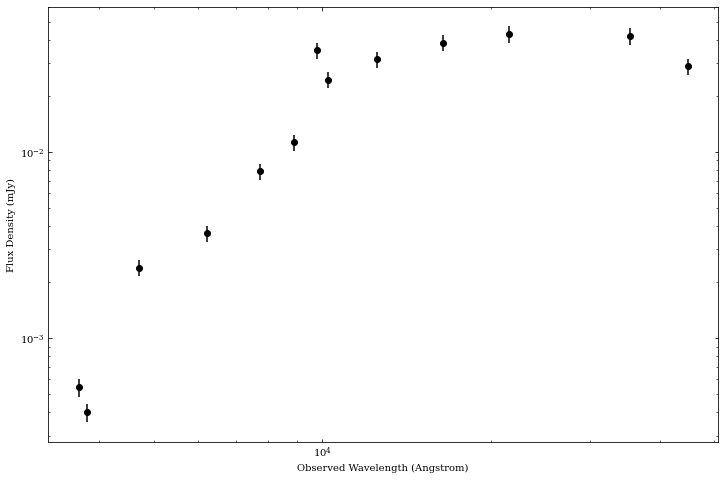

In [ ]:
# Load in the Observed Photometry
# Because our source is at z = 0.9683, we will load the observations FITS file within zbin_0p75_1p00
# Reason these were split in redshift bins was due to computational purposes on the RIT HPC
obs = Table.read("../sed_fitting/cigale/zbin_0p75_1p00/out/observations.fits")

# Find the source 
match = obs['id'] == matched['Id_COS20_Classic'][0]

# Limit to our source of interest
obs = obs[match]

# Filter Properties (Cleaning out just so we can better see the SED Shape)
filters = {"cfht.megacam.u_9302": 3676.12,
           "CFHT_u": 3799.43,
           "subaru.hsc.g": 4710.97,
           "subaru.hsc.r": 6218.44,
           "subaru.hsc.i": 7727.01,
           "subaru.hsc.z": 8908.50,
           "subaru.hsc.y": 9775.07,
           "vista.vircam.Y": 10210.71,
           "vista.vircam.J": 12524.83,
           "vista.vircam.H": 16432.45,
           "vista.vircam.Ks": 21521.52,
           "spitzer.irac.ch1": 35378.41,
           "spitzer.irac.ch2": 44780.49,
           }

plt.figure(figsize=(12, 8))
# Now Let's Plot the Photometry
for key in filters.keys():
    plt.errorbar([filters[key]],[obs[key]], yerr=obs[key+"_err"],fmt = "o",color="black")

plt.xlabel("Observed Wavelength (Angstrom)")
plt.ylabel("Flux Density (mJy)")
plt.xscale("log")
plt.yscale("log")
plt.show()